In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
# matplotlib.rcParams['font.sans-serif'] = "Latin Modern Roman"
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['mathtext.fontset'] = "cm"
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
import xarray as xr
from xgcm import Grid
import numpy as np
import cmocean

In [2]:
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

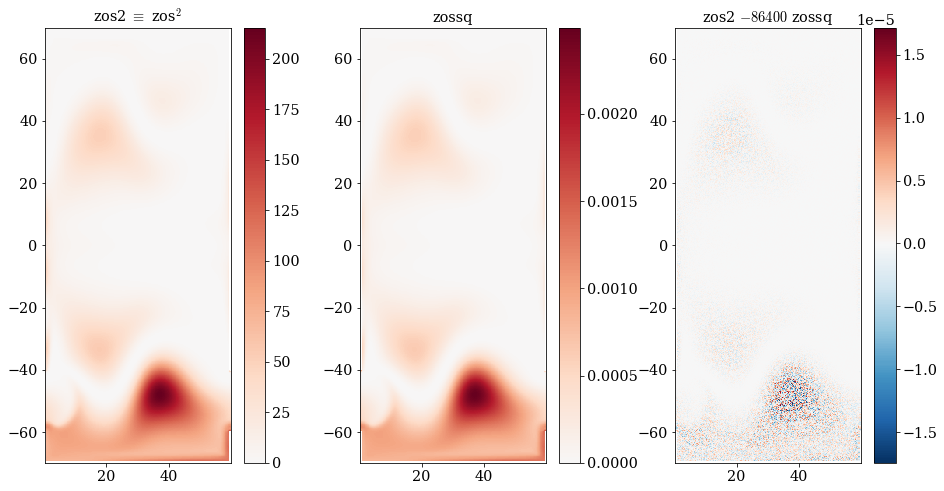

In [3]:
av = xr.open_dataset('run15/averages_00000000.nc', decode_times=False)

plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.pcolormesh(av.xh,av.yh,av.zos2.values[1],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'zos2 $\equiv$ zos$^2$')
plt.colorbar()

plt.subplot(1,3,2)
plt.pcolormesh(av.xh,av.yh,av.zossq.values[1],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'zossq')
plt.colorbar()

plt.subplot(1,3,3)
plt.pcolormesh(av.xh,av.yh,av.zos2.values[1]-av.zossq.values[1]*86400,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'zos2 $- 86400$ zossq')
plt.colorbar()
plt.savefig('Sea surface height.png', dpi=200,bbox_inches='tight',pad_inches=0)

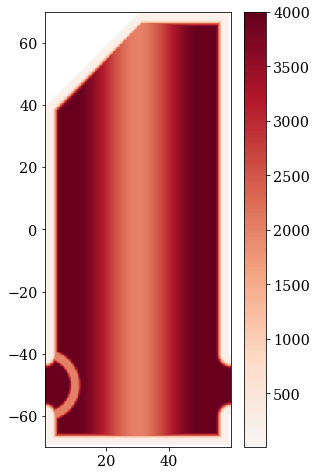

In [4]:
st = xr.open_dataset('run14/static.nc', decode_times=False)
st


plt.figure(figsize=(5,8))
plt.pcolormesh(st.xh,st.yh,st.depth_ocean,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()

## Comparison of effective velocities estimated using 1-day and 5-day averaging

In [5]:
layer_no = 0
end_time = 28500
start_time = end_time - 500

In [6]:
av1 = xr.open_dataset('run9/averages_000%i.nc' % (end_time-500), decode_times=False)
av5 = xr.open_dataset('run9/averages_000%i.nc' % (end_time-500+2), decode_times=False)
st = xr.open_dataset('run9/static.nc', decode_times=False)
lm = xr.open_dataset('run9/longmean_00028250.nc', decode_times=False)

In [7]:
grid = Grid(av1, coords={'X': {'center': 'xh', 'outer': 'xq'},
                        'Y': {'center': 'yh', 'outer': 'yq'},
                        'Z': {'center': 'z_l', 'outer': 'z_i'} }, periodic=['X'])

def interp_h_to_u(h):
    """Interpolate h to the grid points where u is defined"""
    n,layers,ly,lx = h.shape
    h_at_u = np.zeros((n,layers,ly,lx+1))
    h_at_u[:,:,:,1:-1] = (h[:,:,:,:-1] + h[:,:,:,1:])/2
    h_at_u[:,:,:,0] = (h[:,:,:,0] + h[:,:,:,-1])/2 # periodic
    h_at_u[:,:,:,-1] = (h[:,:,:,0] + h[:,:,:,-1])/2 # periodic
    
    return h_at_u
    
def interp_h_to_v(h):
    """Interpolate h to the grid points where v is defined"""
    n,layers,ly,lx = h.shape
    h_at_v = np.zeros((n,layers,ly+1,lx))
    h_at_v[:,:,1:-1,:] = (h[:,:,:-1,:] + h[:,:,1:,:])/2
    h_at_v[:,:,0,:] = h[:,:,0,:] # non-periodic
    h_at_v[:,:,-1,:] = h[:,:,-1,:] # non-periodic
    
    return h_at_v

In [8]:
# 1-day averaged effective zonal velocity
h_at_u = interp_h_to_u(av1.h.astype(float).values) # m
u_eff1 = (av1.uh.astype(float))/(h_at_u*st.dyCu.values.astype(float) + 1e-20) # m/s (divide by st.dyCu [m] to get the right units)

# 5-day averaged effective zonal velocity
h_at_u = interp_h_to_u(av5.h.astype(float).values) # m
u_eff5 = (av5.uh.astype(float))/(h_at_u*st.dyCu.values.astype(float) + 1e-20) # m/s (divide by st.dyCu [m] to get the right units)

# 500-day averaged zonal velocity
u_lm = lm.u.sel(time=slice(start_time,end_time)).values[:,layer_no].astype(float).mean(axis=0)

In [9]:
# 1-day averaged effective meridional velocity
h_at_v = interp_h_to_v(av1.h.values.astype(float)) # m
v_eff1 = (av1.vh.astype(float))/(h_at_v*st.dxCv.values.astype(float) + 1e-20) # m/s (divide by st.dxCv [m] to get the right units)

# 5-day averaged effective meridional velocity
h_at_v = interp_h_to_v(av5.h.values.astype(float)) # m
v_eff5 = (av5.vh.astype(float))/(h_at_v*st.dxCv.values.astype(float) + 1e-20) # m/s (divide by st.dxCv [m] to get the right units)

# 500-day averaged meridional velocity
v_lm = lm.v.sel(time=slice(start_time,end_time)).values[:,layer_no].astype(float).mean(axis=0)

In [45]:
from scipy import signal

In [46]:
lat_i = 36
lat_f = 120
lon_i = 80
lon_f = 160
lat_size = lat_f - lat_i
lon_size = lon_f - lon_i

u1 = u_eff1.sel(time=slice(start_time,end_time)).values[:,layer_no,lat_i:lat_f,lon_i:lon_f]
u5 = u_eff5.sel(time=slice(start_time,end_time)).values[:,layer_no,lat_i:lat_f,lon_i:lon_f]

v1 = v_eff1.sel(time=slice(start_time,end_time)).values[:,layer_no,lat_i:lat_f,lon_i:lon_f]
v5 = v_eff5.sel(time=slice(start_time,end_time)).values[:,layer_no,lat_i:lat_f,lon_i:lon_f]

In [71]:
time = av5.time.sel(time=slice(start_time,end_time)) 

u_fine1 = u1.mean(axis=0) 
v_fine1 = v1.mean(axis=0) 
u_fine5 = u5.mean(axis=0) 
v_fine5 = v5.mean(axis=0)

In [48]:
group = 5
u1_5 = u1.reshape((-1, group, lat_size, lon_size)).mean(axis=1) # 5-day averaged velocity obtained from the 1-day averaged value

In [63]:
u1_5_spatial_mean = (u1_5*u1_5).mean(axis=2).mean(axis=1)
u5_spatial_mean = (u5*u5).mean(axis=2).mean(axis=1)
u = av5.u.sel(time=slice(start_time,end_time)).values[:,layer_no,lat_i:lat_f,lon_i:lon_f]
u_spatial_mean = (u*u).mean(axis=2).mean(axis=1)

In [73]:
u1_5_spatial_mean.shape
time.shape

(100,)

In [72]:
freqs1, psd1 = signal.welch(time,u1_5_spatial_mean)
freqs5, psd5 = signal.welch(time,u5_spatial_mean)
freqs, psd = signal.welch(time,u_spatial_mean)

plt.figure(figsize=(10, 6))
plt.semilogx(freqs, psd)
plt.semilogx(freqs5, psd5)
plt.semilogx(freqs1, psd1)
plt.title('PSD: power spectral density')
plt.legend(('Diagnosed surface u','5-day averaged u (effective)','5-day average of 1-day averaged u (effective)'))
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.tight_layout()

/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 256 is greater than input length  = 100, using nperseg = 100
  .format(nperseg, input_length))


ValueError: operands could not be broadcast together with shapes (51,) (100,) 

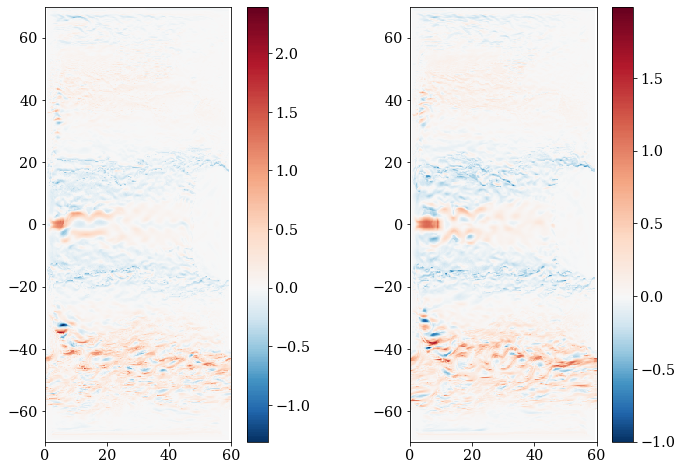

In [58]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.pcolormesh(av1.xq,av1.yh,u_eff1[0,0],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolormesh(av1.xq,av1.yh,u_eff5[0,0],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()

plt.savefig('Comparison_1_and_5_day_velocities.png', dpi=200,bbox_inches='tight',pad_inches=0)

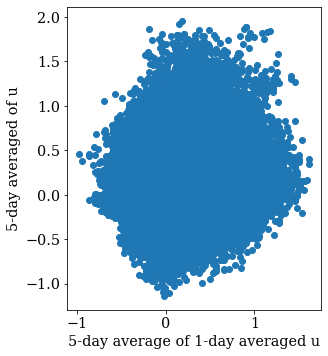

In [60]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.scatter(u1_5,u5)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('5-day average of 1-day averaged u')
plt.ylabel('5-day averaged of u')
plt.gca().set_aspect('equal', adjustable='box')

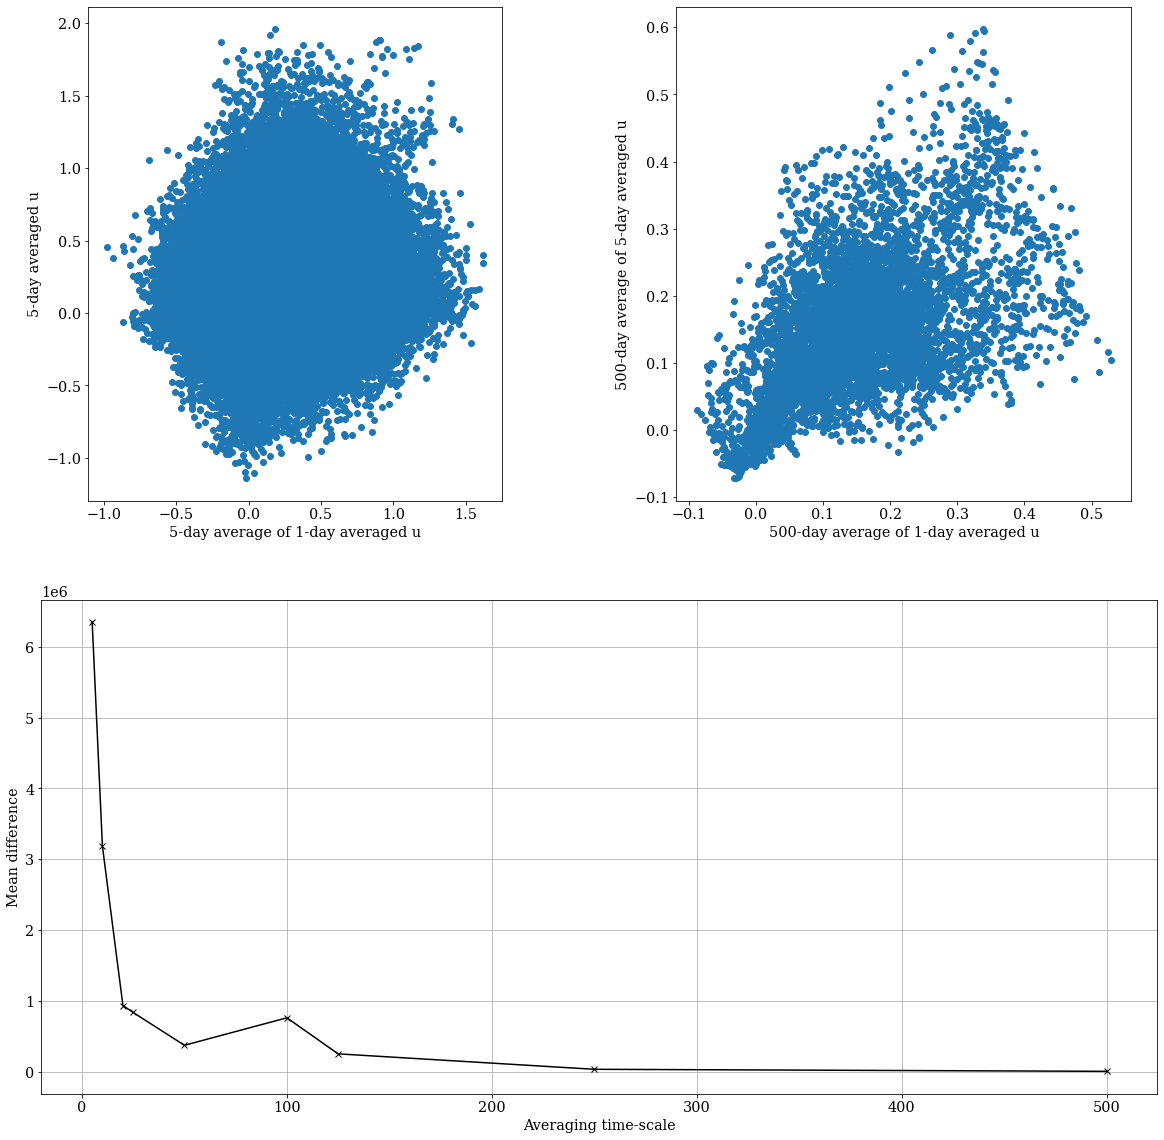

In [61]:
time_avg = [1,2,4,5,10,20,25,50,100]
difference = np.zeros((len(time_avg)))

for i in range(len(time_avg)):
    u1_tavg = u1_5.reshape((-1, time_avg[i], lat_size, lon_size)).mean(axis=1) # longer-time averages estimated from 1-day averaged values
    u5_tavg = u5.reshape((-1, time_avg[i], lat_size, lon_size)).mean(axis=1) # longer-time averages estimated from 5-day averaged values
    difference[i] = np.nansum(abs(u1_tavg-u5_tavg)/abs(u5_tavg)) # Mean difference
    

plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.scatter(u1_5,u5)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('5-day average of 1-day averaged u')
plt.ylabel('5-day averaged u')

plt.subplot(2,2,2)
plt.scatter(u1_tavg,u5_tavg)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('500-day average of 1-day averaged u')
plt.ylabel('500-day average of 5-day averaged u')

plt.subplot(2,1,2)
plt.plot(np.array(time_avg)*5,difference,'kx-')
plt.ylabel('Mean difference')
plt.xlabel('Averaging time-scale')
plt.grid()
plt.savefig('Comparison_velocities.png', dpi=200,bbox_inches='tight',pad_inches=0)

In [62]:
difference

array([6347828.96024031, 3186469.33021945,  938272.66776598,
        839958.5859709 ,  376875.10222139,  764564.63153224,
        256026.41563   ,   38268.03806075,    9409.38814185])